# Vanna.AI Test

https://vanna.ai/docs/snowflake-openai-vanna-vannadb.html

In [1]:
import os
import vanna
from vanna.remote import VannaDefault

In [2]:
api_key = vanna.get_api_key("VANNA_API_KEY")

In [3]:
vanna_model_name = "deadpool-test"
vn = VannaDefault(model=vanna_model_name, api_key=api_key)

In [4]:
SNOW_ACCOUNT = os.environ.get("SNOW_ACCOUNT")
SNOW_USER = os.environ.get("SNOW_USER")
SNOW_PASS = os.environ.get("SNOW_PASS")
SNOW_WAREHOUSE = "DEADPOOL"
SNOW_DATABASE = "DEADPOOL"

vn.connect_to_snowflake(
    account=SNOW_ACCOUNT,
    username=SNOW_USER,
    password=SNOW_PASS,
    database=SNOW_DATABASE,
    role="ENGINEER",
)

### If you need to delete all the training data, you can with this

In [5]:
# At any time you can inspect what training data the package is able to reference
training_data = vn.get_training_data()
training_data

,id,training_data_type,question,content
0,177527-doc,documentation,None,The following columns are in the SCORES table ...
1,45623-ddl,ddl,None,\nCREATE OR REPLACE TRANSIENT TABLE DEADPOOL.P...
2,153738-sql,sql,"What are the total scores of all players, disp...","\nSELECT CONCAT(FIRST_NAME, ' ', LAST_NAME) AS..."
3,153741-sql,sql,Which player has the highest total score and w...,"\nSELECT CONCAT(P.FIRST_NAME, ' ', P.LAST_NAME..."
4,177529-doc,documentation,None,The following columns are in the PICKS table i...
5,153740-sql,sql,"What are the total scores of each player, list...","\nSELECT CONCAT(P.FIRST_NAME, ' ', P.LAST_NAME..."
6,177532-doc,documentation,None,"When you deal with these dataframes, please jo..."
7,153739-sql,sql,What is the name of the oldest person in the d...,\nSELECT NAME\nFROM DEADPOOL.PROD.PICKS\nWHERE...
8,153743-sql,sql,How many players are there in the game?,SELECT COUNT(*) AS TOTAL_PLAYERS\nFROM DEADPOO...
9,153745-sql,sql,Show me the scores of the top 3 players in the...,"SELECT CONCAT(P.FIRST_NAME, ' ', P.LAST_NAME) ..."


In [6]:
for id in training_data['id']:
    vn.remove_training_data(id)

## Only Run This Next Section if There are Changes

In [7]:
# The information schema query may need some tweaking depending on your database. This is a good starting point.
df_information_schema = vn.run_sql("SELECT * FROM INFORMATION_SCHEMA.COLUMNS WHERE (TABLE_NAME = 'PLAYERS' OR TABLE_NAME = 'PICKS' OR TABLE_NAME = 'SCORES') AND TABLE_SCHEMA = 'PROD'")

# This will break up the information schema into bite-sized chunks that can be referenced by the LLM
plan = vn.get_training_plan_generic(df_information_schema)
plan

# If you like the plan, then uncomment this and run it to train
vn.train(plan=plan)

In [8]:
plan

Train on Information Schema: DEADPOOL.PROD PLAYERS
Train on Information Schema: DEADPOOL.PROD SCORES
Train on Information Schema: DEADPOOL.PROD PICKS

In [9]:
# The following are methods for adding training data. Make sure you modify the examples to match your database.

# DDL statements are powerful because they specify table names, colume names, types, and potentially relationships
vn.train(ddl="""
CREATE OR REPLACE TABLE DEADPOOL.PROD.PICKS (
NAME VARCHAR(256),
BIRTH_DATE DATE,
DEATH_DATE DATE,
PICKED_BY VARCHAR(256),
WIKI_PAGE VARCHAR(256),
YEAR NUMBER(38,0),
TIMESTAMP TIMESTAMP_NTZ(9),
WIKI_ID VARCHAR(256),
AGE NUMBER(10,1),
FOREIGN KEY (PICKED_BY) REFERENCES DEADPOOL.PROD.PLAYERS(ID)
);
""")

vn.train(ddl="""
CREATE OR REPLACE TABLE DEADPOOL.PROD.PLAYERS (
FIRST_NAME VARCHAR(256),
LAST_NAME VARCHAR(256),
EMAIL VARCHAR(256),
OPT_IN BOOLEAN,
SMS VARCHAR(256),
ID VARCHAR(36),
PASSWORD VARCHAR(256),
YEAR_ONE NUMBER(10,1),
YEAR_TWO NUMBER(10,1),
PRIMARY KEY (ID)
);
""")

vn.train(ddl="""
CREATE OR REPLACE TRANSIENT TABLE DEADPOOL.PROD.SCORES (
PLAYER_ID VARCHAR(36),
TOTAL NUMBER(38,0),
BASE_SCORE NUMBER(24,1),
FIRST_BLOOD NUMBER(38,0),
LAST_BLOOD NUMBER(38,0),
Q_ONE NUMBER(38,0),
Q_TWO NUMBER(38,0),
Q_THREE NUMBER(38,0),
Q_FOUR NUMBER(38,0),
foreign key (PICKED_BY) references DEADPOOL.PROD.PLAYERS(ID)
);
""")

# Add documentation about your business terminology or definitions.
vn.train(documentation="You are the Arbiter.  You are the judge of the game DEADPOOL. You have access to a data frame with a column called NAME, which represents celebrity picks for this year, 2024.  The PLAYERS column contains the game's participants.")  

vn.train(documentation="When asked about the score or points in the game, you should join the table SCORES on SCORES.ID = PLAYERS.ID. This will allow you certain different values, but the TOTAL column is the value you should retreive.")  

vn.train(documentation="When you deal with these dataframes, please join them together by the ID field in PLAYERS and the PICKED_BY field in PICKS.")

# You can also add SQL queries to your training data. This is useful if you have some queries already laying around. You can just copy and paste those from your editor to begin generating new SQL.
vn.train(sql="""
SELECT CONCAT(FIRST_NAME || ' ' || LAST_NAME) AS PLAYER_NAME, COUNT(NAME) AS TOTAL_PICKS 
FROM PICKS
LEFT JOIN PLAYERS
ON PICKS.PICKED_BY = PLAYERS.ID
WHERE YEAR = 2024 
GROUP BY 1
""")

vn.train(sql="""
SELECT CONCAT(FIRST_NAME, ' ', LAST_NAME) AS PLAYER_NAME, TOTAL
FROM DEADPOOL.PROD.PLAYERS
JOIN DEADPOOL.PROD.SCORES
ON PLAYERS.ID = SCORES.ID
ORDER BY TOTAL DESC;
""")

vn.train(sql="""
SELECT NAME
FROM DEADPOOL.PROD.PICKS
WHERE AGE IS NOT NULL
ORDER BY AGE DESC
LIMIT 1;
""")

vn.train(sql="""
SELECT CONCAT(P.FIRST_NAME, ' ', P.LAST_NAME) AS LEADER, S.TOTAL
FROM PLAYERS P
JOIN SCORES S
ON P.ID = S.PLAYER_ID
ORDER BY S.TOTAL DESC;
""")

vn.train(sql="""
SELECT CONCAT(P.FIRST_NAME, ' ', P.LAST_NAME) AS LEADER, S.TOTAL
FROM PLAYERS P
JOIN SCORES S
ON P.ID = S.PLAYER_ID
ORDER BY S.TOTAL DESC;
""")

Adding ddl: 
CREATE OR REPLACE TABLE DEADPOOL.PROD.PICKS (
NAME VARCHAR(256),
BIRTH_DATE DATE,
DEATH_DATE DATE,
PICKED_BY VARCHAR(256),
WIKI_PAGE VARCHAR(256),
YEAR NUMBER(38,0),
TIMESTAMP TIMESTAMP_NTZ(9),
WIKI_ID VARCHAR(256),
AGE NUMBER(10,1),
FOREIGN KEY (PICKED_BY) REFERENCES DEADPOOL.PROD.PLAYERS(ID)
);

Adding ddl: 
CREATE OR REPLACE TABLE DEADPOOL.PROD.PLAYERS (
FIRST_NAME VARCHAR(256),
LAST_NAME VARCHAR(256),
EMAIL VARCHAR(256),
OPT_IN BOOLEAN,
SMS VARCHAR(256),
ID VARCHAR(36),
PASSWORD VARCHAR(256),
YEAR_ONE NUMBER(10,1),
YEAR_TWO NUMBER(10,1),
PRIMARY KEY (ID)
);

Adding ddl: 
CREATE OR REPLACE TRANSIENT TABLE DEADPOOL.PROD.SCORES (
PLAYER_ID VARCHAR(36),
TOTAL NUMBER(38,0),
BASE_SCORE NUMBER(24,1),
FIRST_BLOOD NUMBER(38,0),
LAST_BLOOD NUMBER(38,0),
Q_ONE NUMBER(38,0),
Q_TWO NUMBER(38,0),
Q_THREE NUMBER(38,0),
Q_FOUR NUMBER(38,0),
foreign key (PICKED_BY) references DEADPOOL.PROD.PLAYERS(ID)
);

Adding documentation....
Adding documentation....
Adding documentation....
Questi

'a2f560578eb6b41107f4781d89963825-sql'

## Ask the Data Some Questions

In [10]:
vn.ask(question="How many players are there in the game?", visualize=False, print_results=False)

('SELECT COUNT(*) AS TOTAL_PLAYERS\nFROM DEADPOOL.PROD.PLAYERS;',
    TOTAL_PLAYERS
 0             14,
 None)

In [19]:
vn.ask(question="Show the first and last name along with the total number of picks for each player", visualize=True, print_results=False)

Couldn't run sql:  002003 (42S02): SQL compilation error:
Object 'PLAYERS' does not exist or not authorized.


("SELECT CONCAT(FIRST_NAME, ' ', LAST_NAME) AS PLAYER_NAME, \n       COUNT(NAME) AS TOTAL_PICKS\nFROM PLAYERS\nLEFT JOIN PICKS ON PLAYERS.ID = PICKS.PICKED_BY\nGROUP BY PLAYER_NAME;",
 None,
 None)

In [17]:
vn.ask(question="Which PLAYER is currently leading the game?", visualize=True)

SELECT CONCAT(P.FIRST_NAME, ' ', P.LAST_NAME) AS LEADER, S.TOTAL
FROM PLAYERS P
JOIN SCORES S
ON P.ID = S.PLAYER_ID
ORDER BY S.TOTAL DESC
LIMIT 1;
Couldn't run sql:  002003 (42S02): SQL compilation error:
Object 'PLAYERS' does not exist or not authorized.


SELECT CONCAT(P.FIRST_NAME, ' ', P.LAST_NAME) AS PLAYER_NAME, S.TOTAL
FROM DEADPOOL.PROD.PLAYERS P
JOIN DEADPOOL.PROD.SCORES S
ON P.ID = S.PLAYER_ID
ORDER BY S.TOTAL DESC
LIMIT 3;
         PLAYER_NAME  TOTAL
0  Alexander O'Brien    254
1       Will Cokeley     88
2        Warren Jahn     74


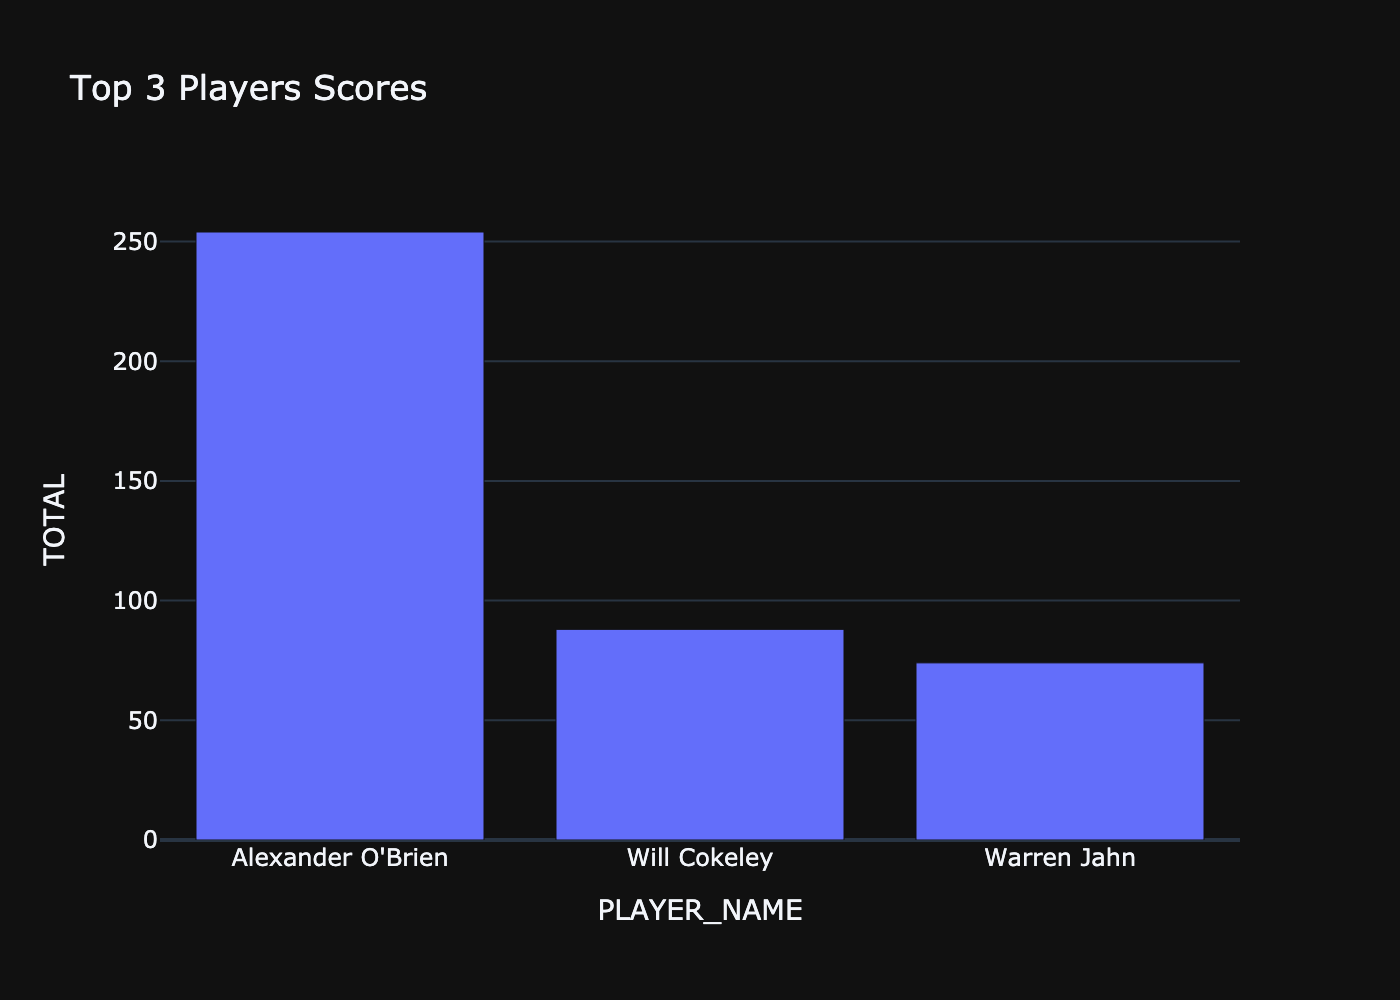

("SELECT CONCAT(P.FIRST_NAME, ' ', P.LAST_NAME) AS PLAYER_NAME, S.TOTAL\nFROM DEADPOOL.PROD.PLAYERS P\nJOIN DEADPOOL.PROD.SCORES S\nON P.ID = S.PLAYER_ID\nORDER BY S.TOTAL DESC\nLIMIT 3;",
          PLAYER_NAME  TOTAL
 0  Alexander O'Brien    254
 1       Will Cokeley     88
 2        Warren Jahn     74,
 None)

In [16]:
vn.ask(question="Show me the scores of the top 3 players in the game?", visualize=True)

In [15]:
vn.generate_sql(question="how many players are there")

'SELECT COUNT(*) AS TOTAL_PLAYERS\nFROM DEADPOOL.PROD.PLAYERS;'

## Run a Local Server

In [14]:
from vanna.flask import VannaFlaskApp
app = VannaFlaskApp(vn, allow_llm_to_see_data=True)
app.run()

Your app is running at:
http://localhost:8084
 * Serving Flask app 'vanna.flask'
 * Debug mode: off
